In [1]:
'''
this one is smart auto encoder, with padding
'''


'\nthis one is smart auto encoder, with padding\n'

In [2]:
import os

In [3]:
# from google.colab import drive

# drive.mount('/content/gdrive')

# root_path = r'gdrive/My Drive/work/research/AutoEncoder_classification/UTKFace/'  #change dir to your project folder

# os.chdir(root_path)

In [46]:

from tensorflow.keras.datasets import mnist

import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, Reshape
from tensorflow.keras.layers import Dense, Cropping2D
from tensorflow.keras.layers import Flatten, MaxPool2D
from tensorflow.keras.layers import Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [5]:
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
import random

### 01 Get the data

In [6]:
# X=np.array(pickle.load(open("pickles/X_resized_grayed.p","rb")))
X=np.array(pickle.load(open("pickles/X_grayed_resized50.p","rb")))

In [7]:
y_genders=np.array(pickle.load(open("pickles/y_genders.p","rb")))
y_ages=np.array(pickle.load(open("pickles/y_ages.p","rb")))

In [8]:
X_adults=[]
y_genders_adults=[]
for i in range(len(X)):
    if y_ages[i]>18 and y_ages[i]<60:
        X_adults.append(X[i])
        y_genders_adults.append(y_genders[i])
X_adults=np.array(X_adults)
y_genders_adults=np.array(y_genders_adults)

In [9]:
print("Number of images filtered of adults = ",X_adults.shape, y_genders_adults.shape)

Number of images filtered of adults =  (4222, 100, 100) (4222,)


In [10]:
# lim=5000
# X=X[:]
# y_genders=y_genders[:]

In [11]:
X.shape

(9778, 100, 100)

In [12]:
len(X)

9778

In [13]:
x_train, x_test, y_train, y_test = train_test_split(X_adults, y_genders_adults, test_size=0.33,random_state=42)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2828, 100, 100) (2828,)
(1394, 100, 100) (1394,)


In [14]:
# x_train = np.reshape(x_train, (len(x_train), 3, 200, 200))
# x_test = np.reshape(x_test, (len(x_test), 3, 200, 200))

In [15]:
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(2828, 100, 100) (2828,)
(1394, 100, 100) (1394,)


In [16]:
autoenc_epochs=10
cnn_epochs=100

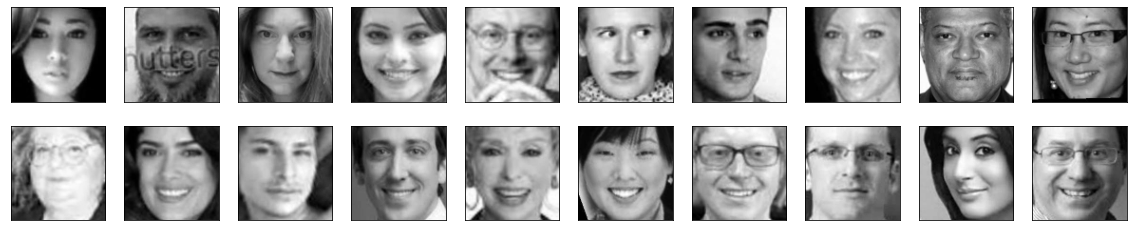

In [17]:
# before padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


#### 01a Pad the train data with -1 for left hand side

In [18]:
# variable: how much padding is good padding
# in this case the matrix is 200X200
# shall we take 10% of the size
# and pad that on all sides


In [19]:
perc=0.2
pad=int(perc*x_train[0].shape[1])
print("Number of rows on both sides = ",pad)
padding_val=127/255

denom=max(y_train)-min(y_train)
print(denom)



Number of rows on both sides =  20
1


In [20]:
def pad_multi(matrix,col_padding, row_padding,values):
    '''
    matrix shape: count X rows X columns X channels
    col_padding: (left_padding, right_padding)
    row_padding: (up_padding, below_padding)
    value: value to pad with
    '''
#     b=np.pad(a, ((1,1), (1,1), (0,0)), mode='constant',constant_values=(9))

    all_padded=[]
    for i in range(matrix.shape[0]):
        new_padded=np.pad(matrix[i],(col_padding,row_padding,(0,0)),'constant',constant_values=(values[i]))
#         this_padded.append(np.pad(matrix[i][0],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][1],padding_length,'constant',constant_values=(values[i])))
#         this_padded.append(np.pad(matrix[i][2],padding_length,'constant',constant_values=(values[i])))        
        all_padded.append(new_padded)
    all_padded=np.array(all_padded)
    return all_padded
        
        

In [21]:
def pad_single_channel(matrix,col_padding,row_padding,values):
    all_padded=[]
    for i in range(matrix.shape[0]):
        new_mat=np.pad(matrix[i],(col_padding,row_padding),'constant',constant_values=(values[i]))
        all_padded.append(new_mat)
    all_padded=np.array(all_padded)
    return all_padded
        

In [22]:
values=[padding_val for i in range(x_train.shape[0])]
x_train_left=pad_single_channel(x_train,(pad,pad),(pad,pad),values)

rows=x_train_left.shape[1]
cols=x_train_left.shape[2]
print(rows,cols)

x_train_left=x_train_left.reshape(len(x_train_left),rows,cols,1)
print(x_train_left.shape)
# x_train_left = np.reshape(x_train_left, (len(x_train_left), 30, 30, 1))


140 140
(2828, 140, 140, 1)


In [23]:
print(x_train[0].shape,x_train_left[0].shape)

(100, 100) (140, 140, 1)


In [24]:
# x_train_left[10][0][20]

#### 01b Pad the train data with y_values for right hand side

In [25]:
(y_train[9])/denom 

0.0

In [26]:
val=[y_train[i]/denom for i in range(y_train.shape[0])]
x_train_right=pad_single_channel(x_train,(pad,pad),(pad,pad),val)

rows=x_train_right.shape[1]
cols=x_train_right.shape[2]
print(rows,cols)


x_train_right=x_train_right.reshape(len(x_train_right),rows,cols,1)

print(x_train_right.shape)

140 140
(2828, 140, 140, 1)


In [27]:
# x_train_right[10][0][20]

#### 01c Pad the test data with -1 for left hand side

In [28]:
values=[padding_val for i in range(x_test.shape[0])]
random.seed(12)
# values=[random.random() for i in range(x_train.shape[0])]

x_test_left=pad_single_channel(x_test,(pad,pad),(pad,pad),values)

rows=x_test_left.shape[1]
cols=x_test_left.shape[2]
print(rows,cols)


x_test_left=x_test_left.reshape(len(x_test_left),rows,cols,1)
print(x_test_left.shape)

140 140
(1394, 140, 140, 1)


#### 01d Pad the test data with y values for right hand side

In [29]:
x_test_right=[]

val=[y_test[i]/denom for i in range(y_test.shape[0])]


x_test_right=pad_single_channel(x_test,(pad,pad),(pad,pad),val)

rows=x_test_right.shape[1]
cols=x_test_right.shape[2]
print(rows,cols)

x_test_right=x_test_right.reshape(len(x_test_right),rows,cols,1)
print(x_test_right.shape)    

140 140
(1394, 140, 140, 1)


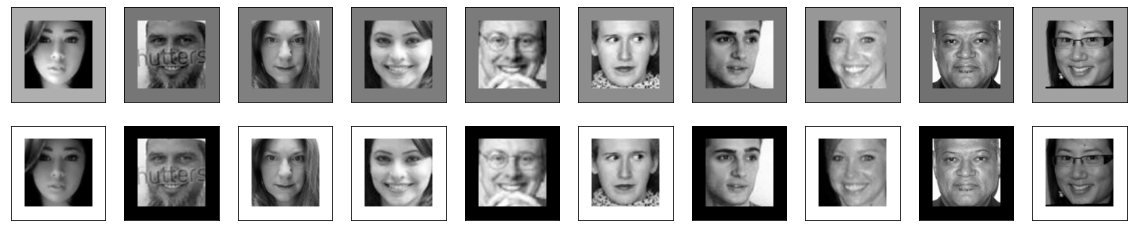

In [30]:
# after padding

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
#     print(x_train_right[i].shape)
    plt.imshow(x_train_left[i].reshape(rows,cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_train_right[i].reshape(rows,cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### 02 Create and train the model

In [ ]:
# x_train_right[2][0]

In [37]:
input_img = keras.Input(shape=x_train_left[0].shape)





x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)

x = layers.MaxPooling2D((2, 2), padding='same')(x)

encoded=layers.Flatten() (x)

x=layers.Reshape((35,35,8)) (encoded)

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu',padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)

decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 140, 140, 1)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 140, 140, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 70, 70, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9800)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 35, 35, 8)         0   

In [ ]:
flat_shape=x_train_left[0].shape[0]*x_train_left[0].shape[1]*x_train_left[0].shape[2]

In [ ]:
# input_img = keras.Input(shape=x_train_left[0].shape)
# x = layers.Conv2D(32, (3, 3),strides=1, activation='relu', padding='same')(input_img)
# x = layers.Flatten() (x)
# x = layers.Dense(2000, activation='relu') (x)
# x = layers.Dense(1000, activation='relu') (x)
# x = layers.Dense(500, activation='relu') (x)

# encoded = layers.Dense(250, activation='relu') (x)

# x = layers.Dense(500, activation = "relu") (encoded)
# x = layers.Dense(1000, activation = "relu") (x)
# x = layers.Dense(2000, activation = "relu") (x)
# x = layers.Dense(flat_shape, activation='sigmoid')(x)
# decoded = layers.Reshape(x_train_left[0].shape) (x)


# autoencoder = keras.Model(input_img, decoded)
# autoencoder.summary()
# autoencoder.compile(optimizer='adam',metrics=["accuracy"], loss='binary_crossentropy')

In [ ]:
# # from: https://github.com/rtflynn/Cifar-Autoencoder/blob/master/denoising_autoencoder.py

# input_img = keras.Input(shape=x_train_left[0].shape)

# x = layers.Conv2D(32, (3, 3),strides=1, activation='relu', padding='same')(input_img)
# x = layers.BatchNormalization() (x)
# x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(x)
# x = layers.Conv2D(32, (3, 3), strides=1, activation='relu', padding='same')(x)
# encoded = layers.BatchNormalization() (x)

# # encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# # x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
# x = layers.UpSampling2D((2,2))(encoded)
# x = layers.Conv2D(32, (3, 3),strides=1, activation='relu',padding='same')(x)
# x = layers.BatchNormalization() (x)

# decoded = layers.Conv2D(1, (1, 1),strides=1, activation='sigmoid', padding='same')(x)

# autoencoder = keras.Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', metrics=['accuracy'], loss='mean_squared_error')
# autoencoder.summary()

In [38]:
history=autoencoder.fit(x_train_left, x_train_right,
                epochs=30,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_left, x_test_right))


Epoch 1/30
23/23 [==============================] - 15s 621ms/step - loss: 0.6934 - val_loss: 0.6845
Epoch 2/30
23/23 [==============================] - 14s 592ms/step - loss: 0.6815 - val_loss: 0.6629
Epoch 3/30
23/23 [==============================] - 14s 591ms/step - loss: 0.6581 - val_loss: 0.6527
Epoch 4/30
23/23 [==============================] - 14s 595ms/step - loss: 0.6533 - val_loss: 0.6421
Epoch 5/30
23/23 [==============================] - 14s 594ms/step - loss: 0.6417 - val_loss: 0.6464
Epoch 6/30
23/23 [==============================] - 14s 596ms/step - loss: 0.6441 - val_loss: 0.6370
Epoch 7/30
23/23 [==============================] - 14s 599ms/step - loss: 0.6428 - val_loss: 0.6377
Epoch 8/30
23/23 [==============================] - 14s 592ms/step - loss: 0.6397 - val_loss: 0.6368
Epoch 9/30
23/23 [==============================] - 14s 596ms/step - loss: 0.6385 - val_loss: 0.6350
Epoch 10/30
23/23 [==============================] - 14s 593ms/step - loss: 0.6389 - val_lo

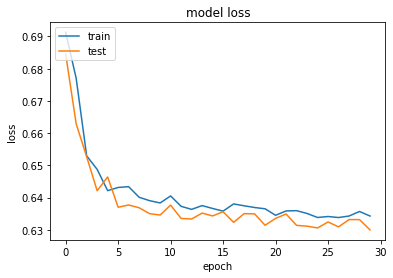

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'][:])
plt.plot(history.history['val_loss'][:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

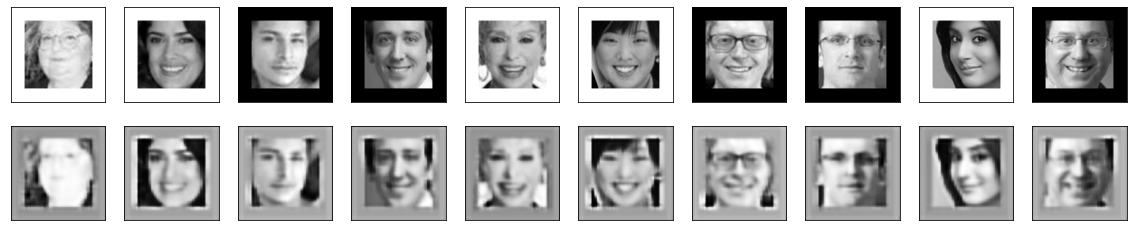

In [40]:
decoded_imgs = autoencoder.predict(x_test_left)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_right[i].reshape(rows,cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(rows,cols))
    plt.gray()

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [41]:
autoencoder.save("models/btchn_autoencoder_with_label.h")

INFO:tensorflow:Assets written to: models/btchn_autoencoder_with_label.h/assets


In [42]:
new_autoenc=load_model("models/btchn_autoencoder_with_label.h")

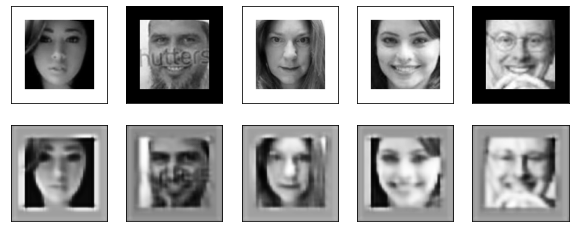

In [43]:
decoded_imgs = new_autoenc.predict(x_train_left)

n = 5
plt.figure(figsize=(10, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train_right[i].reshape(rows, cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(rows, cols))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("figures/utk_batchN_labelled.svg")
# plt.show()


### 03 Extract features and test with LogReg

In [55]:

encoder = Model(inputs=input_img, outputs=encoded)
# decoder=Model(inputs=encoded,outputs=decoded)
encoder.save('models/btchn_encoder_with_label.h5')
# decoder.save('models/decoder_with_label.h5')

In [ ]:
def flatten_encoded_images_for_logreg(X_array):
    print(X_array.shape)
    X_array_flattened=[]
    for i in range(X_array.shape[0]):
        X_array_flattened.append(X_array[i].flatten())
    X_array_flattened=np.array(X_array_flattened)
    print("Shape is ",X_array_flattened.shape)
    return X_array_flattened

In [ ]:
# load the model from file
encoder = load_model('models/btchn_encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
x_train_encode_flat=flatten_encoded_images_for_logreg(x_train_encode)

# x_train_encode=x_train_encode.flatten()
print("Shape of encoded flat",x_train_encode_flat.shape)
# encode the test data
x_test_encode = encoder.predict(x_test_left)
x_test_encode_flat=flatten_encoded_images_for_logreg(x_test_encode)
print("Shape of encoded flat",x_test_encode_flat.shape)



In [ ]:
# define the model
model = LogisticRegression()
# fit the model on the training set
model.fit(x_train_encode_flat, y_train)
# make predictions on the test set
yhat = model.predict(x_test_encode_flat)
# calculate classification accuracy
acc = accuracy_score(y_test, yhat)
print(acc)

### 04 Extract features and Test with a CNN

In [ ]:
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5

#### 04a Convert y values to categorical

In [ ]:
#one-hot encode target column
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
print(y_train_one_hot.shape,y_test_one_hot.shape)

#### 04b Extract features using encoder

In [ ]:
# load the model from file
encoder = load_model('models/btchn_encoder_with_label.h5')
# encode the train data
x_train_encode = encoder.predict(x_train_left)
print("Shape of training encoded images",x_train_encode.shape)

# encode the test data
x_test_encode = encoder.predict(x_test_left)
print("Shape of testing encoded images",x_test_encode.shape)


In [ ]:
print(x_train_encode[0].shape,x_test_encode[1].shape)

### 04c create a CNN that takes encoded image as input

In [ ]:

    

def get_model(x_train):
    # define a CNN to make the predictions
    #create model
    model = Sequential()#add model layers
    model.add(Conv2D(24, kernel_size=5, padding="same", activation='relu', input_shape=x_train[0].shape))
    model.add(MaxPool2D())
    model.add(Conv2D(48, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D())
    model.add(Conv2D(64, kernel_size=5, padding="same", activation='relu'))
    model.add(MaxPool2D(padding='same'))
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])    
    return model
    
# from: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def define_model_VGG3(x_train):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=x_train[0].shape))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
acc_list=[]
for i in range(10):
    model=define_model_VGG3(x_train_encode)
    # print(model.summary())
    #train the model
    num_epochs=100
    history=model.fit(x_train_encode, y_train_one_hot, validation_data=(x_test_encode, y_test_one_hot), epochs=num_epochs,verbose=1)
    loss,acc=model.evaluate(x_test_encode, y_test_one_hot)
    print("Accuracy is ",acc)
    acc_list.append(acc)


In [ ]:
print(sum(acc_list)/len(acc_list))


In [ ]:
# 0.8397417604923249


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### 05 Augmentation

In [44]:
autoencoder=load_model("models/btchn_autoencoder_with_label.h")
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 140, 140, 1)]     0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 140, 140, 16)      160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 70, 70, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 8)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9800)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 35, 35, 8)         0   

In [47]:
idx = 5  # index of desired layer
input_shape = autoencoder.layers[idx].get_input_shape_at(0) # get the input shape of desired layer
print("input shape",input_shape)
layer_input = Input(shape=input_shape) # a new input tensor to be able to feed the desired layer

# create the new nodes for each layer in the path
x = layer_input
for layer in autoencoder.layers[idx:]:
    x = layer(x)

# create the model
just_decoder = Model(layer_input, x)

input shape (None, 35, 35, 8)


In [48]:
just_decoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, 35, 35, 8)] 0         
_________________________________________________________________
flatten_2 (Flatten)          multiple                  0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 35, 35, 8)         584       
_________________________________________________________________
up_sampling2d_6 (UpSampling2 (None, 70, 70, 8)         0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 70, 70, 16)        1168      
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 140, 140, 16)      0   

#### 05a Segregate the images into two categories

In [94]:
limit=500


In [95]:
y_train_reduced=[]
for i in range(limit):
    y_train_reduced.append(y_train[i])

In [96]:
import collections
counter=collections. Counter(y_train_reduced)
print(counter)

Counter({1: 283, 0: 217})


In [97]:
y_imbalanced=np.array(y_train_reduced)
    


In [98]:
import collections
counter=collections. Counter(y_imbalanced)
print(counter)

Counter({1: 283, 0: 217})


In [99]:
encoder = load_model('models/btchn_encoder_with_label.h5')
features_extracted = np.array(encoder(x_train_left[:limit]))
print(features_extracted.shape)
final_out=just_decoder(features_extracted)
print(final_out.shape)

(500, 9800)
(500, 140, 140, 1)


In [100]:
import sys
sys.path
sys.path.append('/lustre/gfxhome/asislam25/projects/augment/KEEL_Data/SMOTE_Variants/smote_variants/smote_variants/')
# print(sys.path)
import time

import importlib
import smote_v_ashhad as sv
importlib.reload(sv)

Imported the sv again
Updating  JUST_DUPLI
Updated KNNOR to fractional neighbor count


<module 'smote_v_ashhad' from '/lustre/gfxhome/asislam25/projects/augment/KEEL_Data/SMOTE_Variants/smote_variants/smote_variants/smote_v_ashhad.py'>

In [101]:
minor_dist=0.9
minor_nbrs=20
major_nbrs=1
max_dist=0.03
proportion=0.3

oversampler= sv.KNNOR_SMOTE(dist_threshold=minor_dist,max_dist=max_dist,
                            n_neighbors=minor_nbrs,n_maj_neighbors=major_nbrs,proportion=proportion)


In [102]:
X_samp2, y_samp2= oversampler.sample(features_extracted, y_imbalanced)

2021-03-30 13:02:19,863:INFO:KNNOR_SMOTE: Running sampling via ('KNNOR_SMOTE', "{'proportion': 0.3, 'n_neighbors': 20, 'n_maj_neighbors': 1, 'dist_threshold': 0.9, 'max_dist': 0.03, 'n_jobs': 1, 'random_state': None}")
2021-03-30 13:02:19,863:INFO:KNNOR_SMOTE: Running sampling via ('KNNOR_SMOTE', "{'proportion': 0.3, 'n_neighbors': 20, 'n_maj_neighbors': 1, 'dist_threshold': 0.9, 'max_dist': 0.03, 'n_jobs': 1, 'random_state': None}")
2021-03-30 13:02:19,863:INFO:KNNOR_SMOTE: Running sampling via ('KNNOR_SMOTE', "{'proportion': 0.3, 'n_neighbors': 20, 'n_maj_neighbors': 1, 'dist_threshold': 0.9, 'max_dist': 0.03, 'n_jobs': 1, 'random_state': None}")
2021-03-30 13:02:19,863:INFO:KNNOR_SMOTE: Running sampling via ('KNNOR_SMOTE', "{'proportion': 0.3, 'n_neighbors': 20, 'n_maj_neighbors': 1, 'dist_threshold': 0.9, 'max_dist': 0.03, 'n_jobs': 1, 'random_state': None}")


GOing to add  19  points
Using  20  neighbors
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use
Cannot use


In [103]:
X_samp2, y_samp2= X_samp2[len(features_extracted):], y_samp2[len(y_imbalanced):]

In [104]:
new_codes= np.array(X_samp2)
decoded_augmented_out=just_decoder(new_codes)
decoded_augmented_out=np.array(decoded_augmented_out)



In [105]:
decoded_augmented_out.shape

(19, 140, 140, 1)

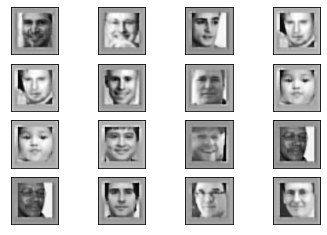

In [107]:
n=decoded_augmented_out.shape[0]
fig,axs=plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        cnt=i*3+j
        axs[i][j].imshow(decoded_augmented_out[cnt])
        axs[i][j].get_xaxis().set_visible(False)
        axs[i][j].get_yaxis().set_visible(False)

fig.savefig("figures/new_faces2.svg")